In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
from functools import partial

from molfeat.trans import MoleculeTransformer
from molfeat.trans.fp import FPVecTransformer
from rdkit.rdBase import BlockLogs

from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from modAL.models import ActiveLearner

from openadmet_models.tests.datafiles import AChE_CHEMBL4078_Landrum_maxcur

import umap

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(rc={"figure.dpi": 600})
sns.set_style("whitegrid", {'axes.grid' : False})
import zarr

In [2]:
RANDOM_STATE = 1234
np.random.seed(RANDOM_STATE)

### Load/visualize

In [3]:
# Load broad dataset ECFP4 fingerprints
X_chembl = np.load("chembl_ecfp4.npy")
idx = np.random.choice(X_chembl.shape[0], 50000)
X_chembl = X_chembl[idx, :]
X_chembl.shape

(50000, 2000)

In [4]:
# Load target data
data = pd.read_csv(AChE_CHEMBL4078_Landrum_maxcur)

# Separate SMILES and targets
smiles = data["canonical_smiles"]
y = data["pchembl_value"]


In [5]:
# Initialize featurizer
vec_featurizer = FPVecTransformer("ecfp:4", dtype=np.float32)
trans = MoleculeTransformer(
            vec_featurizer,
            n_jobs=-1,
            dtype=np.float32,
            parallel_kwargs={"progress": True},
            verbose=False,
        )

# Featurize
with BlockLogs():
    X, _ =  trans(smiles, ignore_errors=True)
 
# Drop extra dim   
X = np.squeeze(X)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2419/2419 [00:01<00:00, 1261.23it/s]


In [6]:
# Initialize UMAP
projector = umap.UMAP(
    n_neighbors=25,
    n_components=2,
    low_memory=False,
    min_dist=0.001,
    random_state=RANDOM_STATE
)

# Fit UMAP to all of ChEMBL
X_chembl_umap = projector.fit_transform(X_chembl)

In [7]:
# Apply to all target data
X_umap = projector.transform(X)

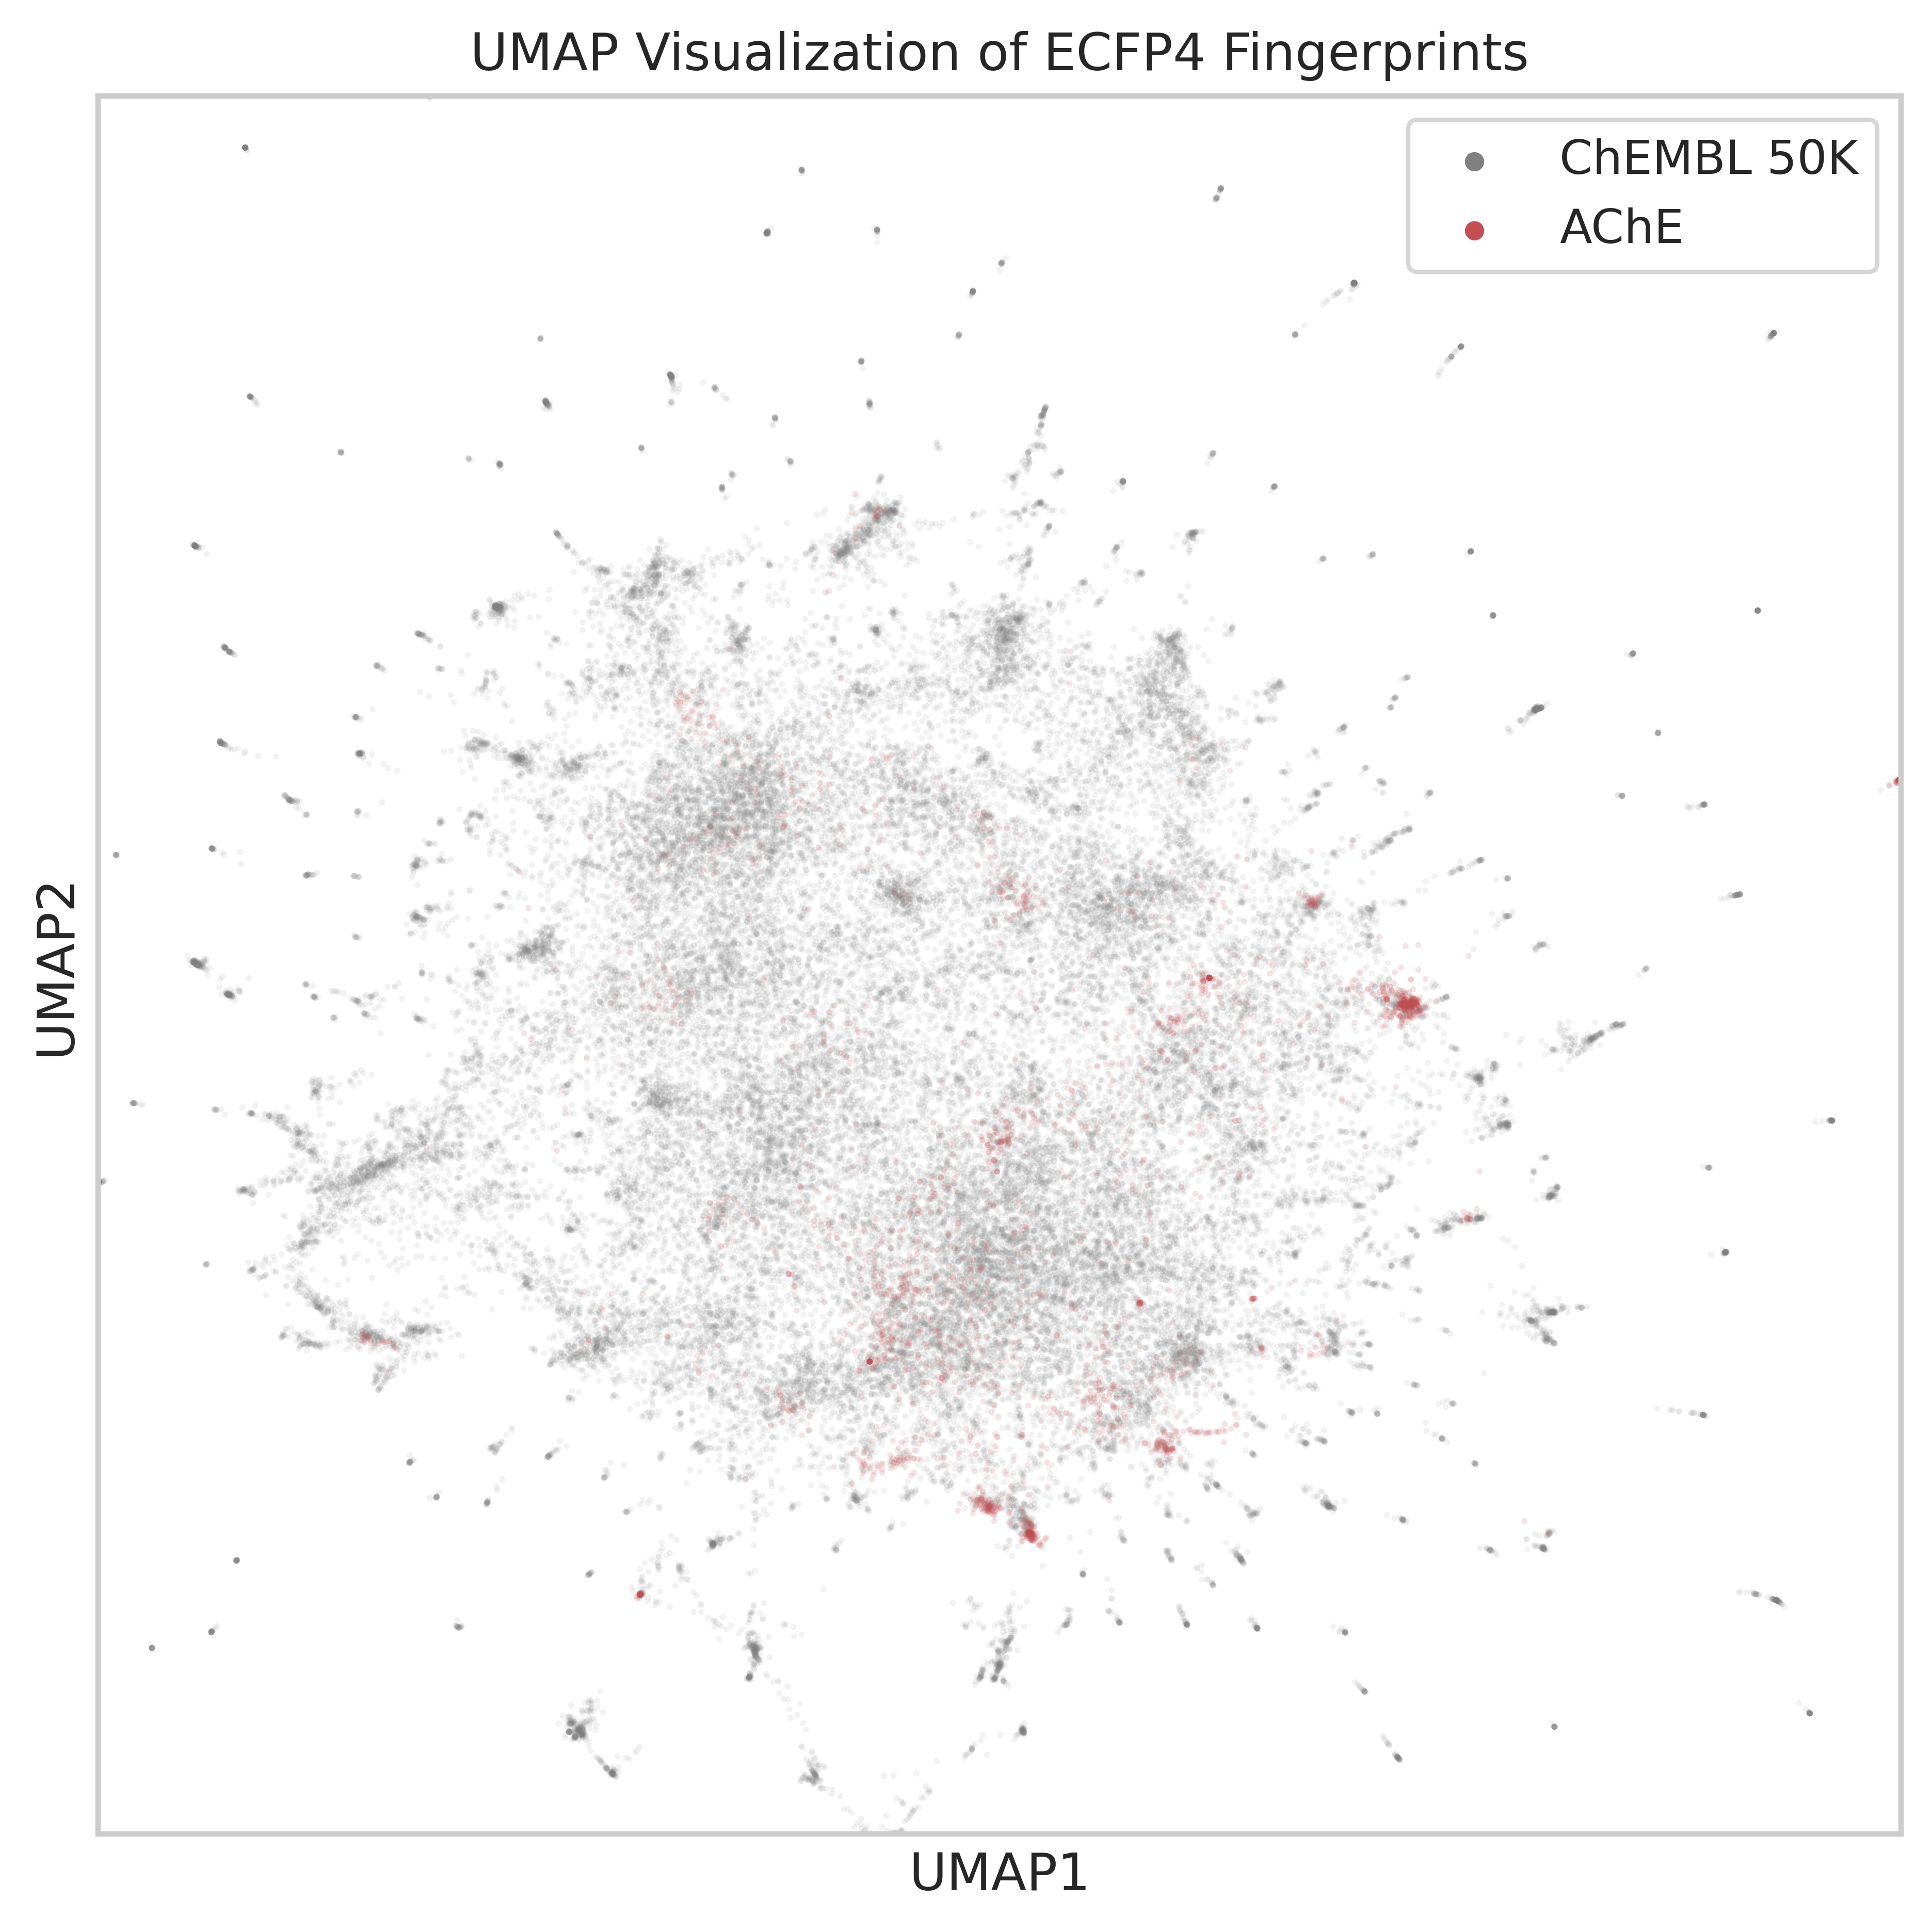

In [8]:
# plot the result
fig, ax = plt.subplots(1, figsize=(6.4, 6.4), dpi=600)

ax.scatter(
    X_chembl_umap[:, 0], 
    X_chembl_umap[:, 1], 
    c="gray", 
    edgecolors="none", 
    s=2, 
    label="ChEMBL 50K",
    alpha=0.1
    )

ax.scatter(
    X_umap[:, 0],
    X_umap[:, 1], 
    c="C3", 
    edgecolors="none", 
    s=2, 
    label="AChE", 
    alpha=0.15
    )

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlim(
    np.quantile(X_chembl_umap[:, 0], 0.01),
    np.quantile(X_chembl_umap[:, 0], 0.99)
    )

ax.set_ylim(
    np.quantile(X_chembl_umap[:, 1], 0.01),
    np.quantile(X_chembl_umap[:, 1], 0.99)
    )

ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")

ax.set_title("UMAP Visualization of ECFP4 Fingerprints")

leg = ax.legend(loc="upper right")
for lh in leg.legend_handles:
    lh.set_alpha(1)
    lh.set_sizes([20])

plt.tight_layout()
plt.show()

### Active learning

In [9]:
def GP_regression_std(regressor, X, n_samples=1):
    """Custom query strategy for Gaussian processes. Returns the instance within `X` with highest standard deviation.

    Parameters
    ----------
    regressor : estimator object
        Regressor.
    X : np.array
        Pool of examples.

    Returns
    -------
    index : int
        Query index.
    X_i : np.array
        Query instance.
    """
    # Predict on available points
    _, std = regressor.predict(X, return_std=True)
    
    # Take largest N standard devs
    query_idx = np.argsort(std)[-n_samples:]
    
    return query_idx, X[query_idx]

In [10]:
# Test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
X_train = np.squeeze(X_train)
X_test = np.squeeze(X_test)

y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

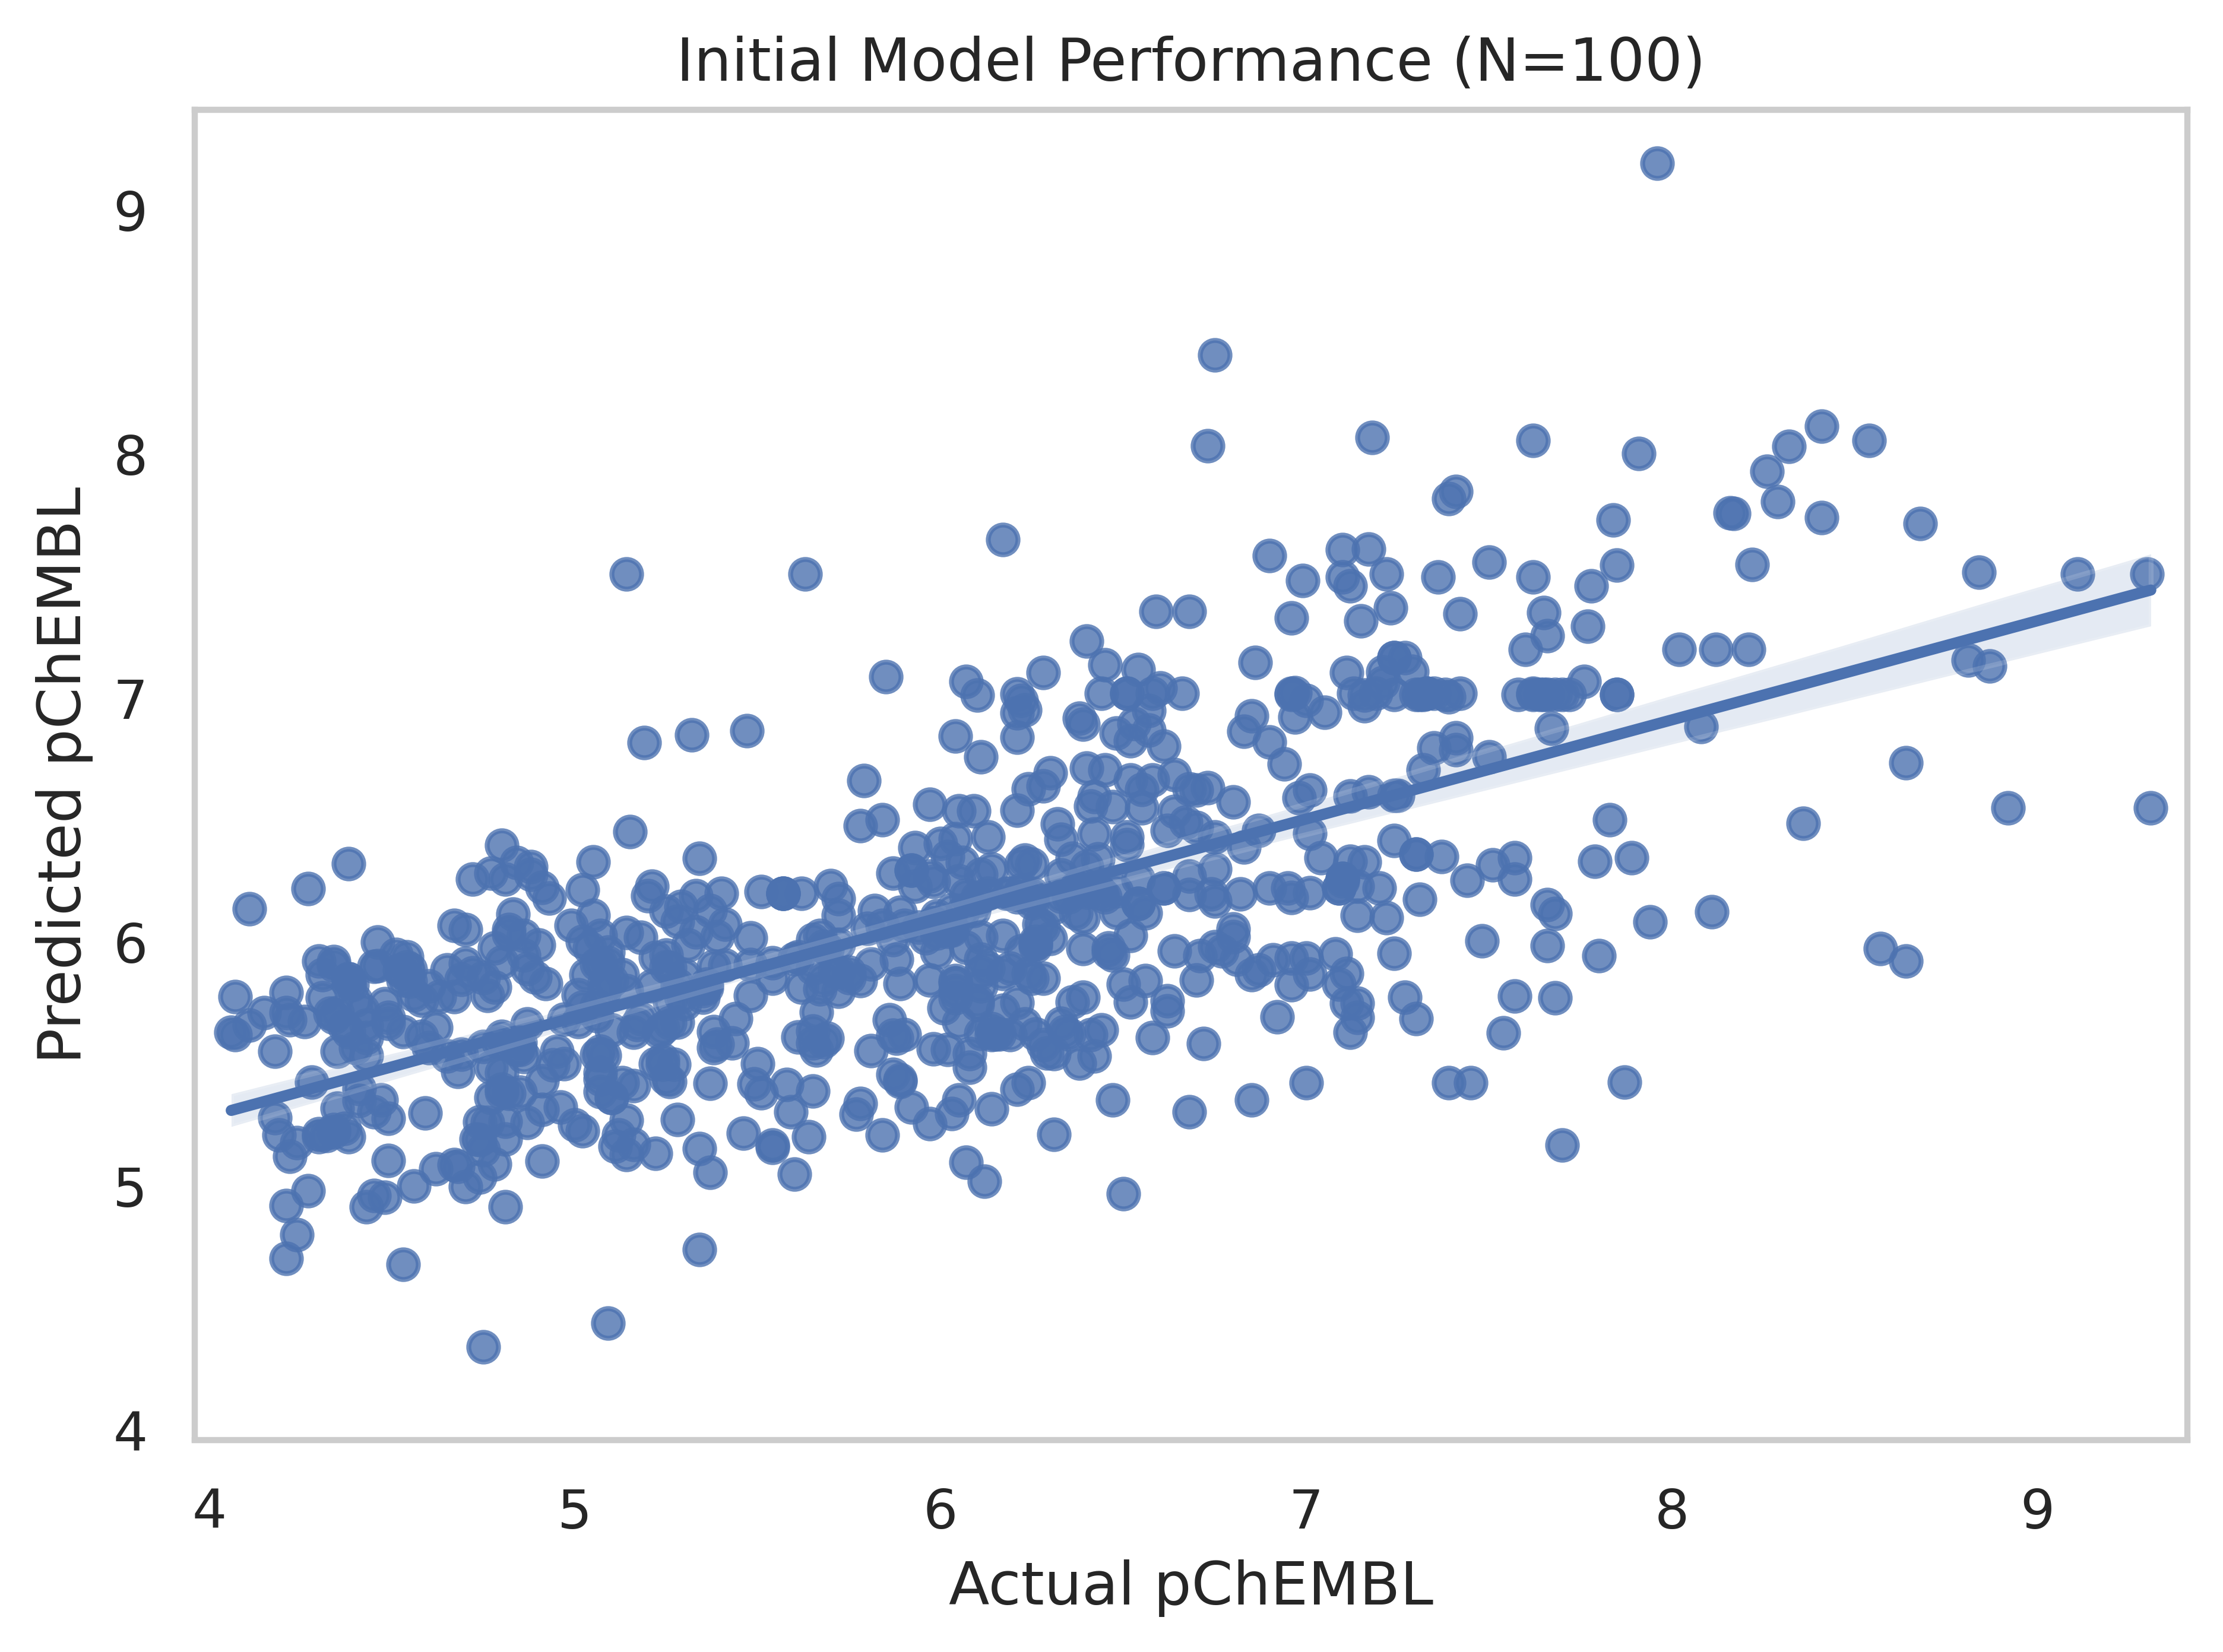

In [11]:
# Initial low-data sampling
n_initial = 100
n_samples_per_iter = 100
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)

# Initialize kernel
kernel = RBF(
    length_scale=1.0, 
    length_scale_bounds=(1e-5, 1e5)
    )
kernel += WhiteKernel(
        noise_level=1, 
        noise_level_bounds=(1e-10, 1e+1)
        )
            
# Initialize active learner      
regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel, normalize_y=True),
    # N samples at a time
    query_strategy=partial(GP_regression_std, n_samples=n_samples_per_iter),
    X_training=X_train[initial_idx, :],
    y_training=y_train[initial_idx]
    )

# Plot initial model result (should be terrible)
y_pred_test, y_std_test = [x.ravel() for x in regressor.predict(X_test, return_std=True)]
ax = sns.regplot(x=y_test, y=y_pred_test)

ax.set_xlabel("Actual pChEMBL")
ax.set_ylabel("Predicted pChEMBL")

ax_min = np.min((np.min(y_test), np.min(y_pred_test))) - 0.1
ax_max = np.max((np.max(y_test), np.max(y_pred_test))) + 0.1

ax.set_xlim(ax_min, ax_max)
ax.set_ylim(ax_min, ax_max)

ax.set_title(f"Initial Model Performance (N={n_initial})")

plt.tight_layout()
plt.show()

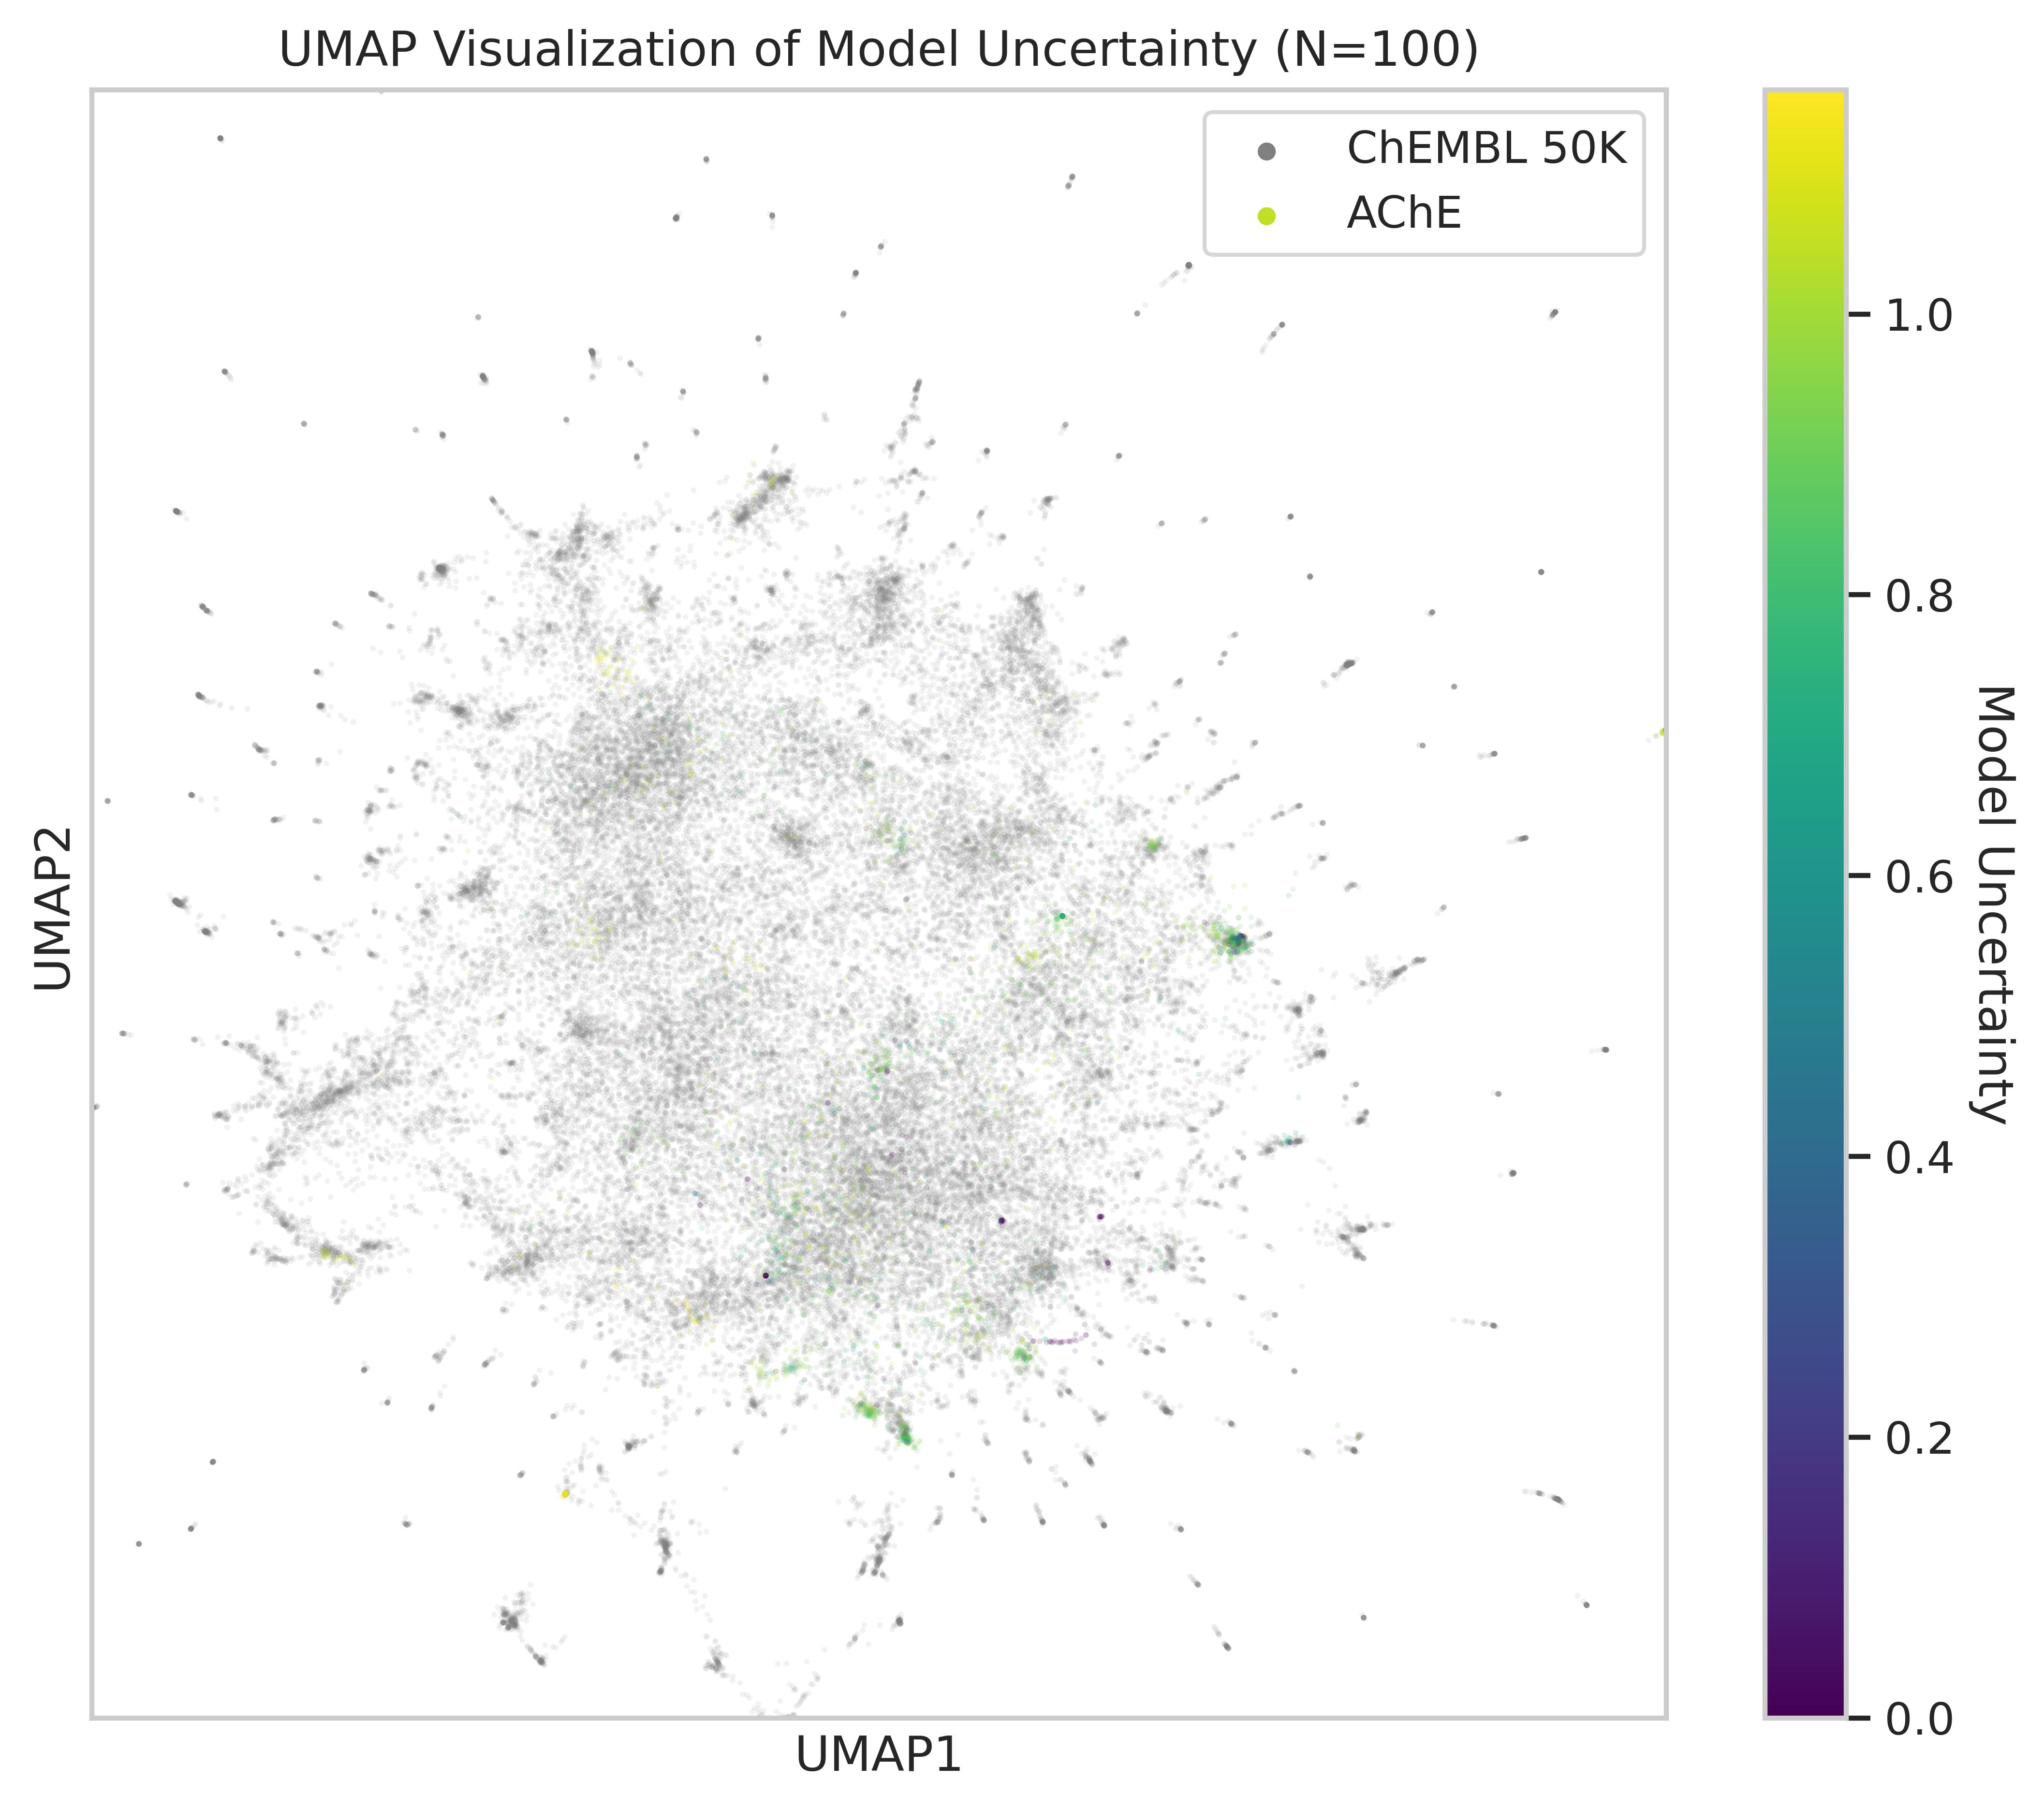

In [12]:
# Plot model uncertainty
y_pred_0, y_std_0 = [x.ravel() for x in regressor.predict(X, return_std=True)]

fig, ax = plt.subplots(1, figsize=(6.4 * 1.15, 6.4), dpi=600)

ax.scatter(
    X_chembl_umap[:, 0], 
    X_chembl_umap[:, 1], 
    c="gray", 
    edgecolors="none", 
    s=2, 
    label="ChEMBL 50K",
    alpha=0.1
    )

points = ax.scatter(
    X_umap[:, 0],
    X_umap[:, 1], 
    c=y_std_0, 
    edgecolors="none", 
    s=2, 
    label="AChE", 
    alpha=0.15,
    cmap="viridis",
    vmin=0,
    vmax=y_std_0.max()
    )

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlim(
    np.quantile(X_chembl_umap[:, 0], 0.01),
    np.quantile(X_chembl_umap[:, 0], 0.99)
    )

ax.set_ylim(
    np.quantile(X_chembl_umap[:, 1], 0.01),
    np.quantile(X_chembl_umap[:, 1], 0.99)
    )

cbar = fig.colorbar(points, ax=ax)
cbar.solids.set(alpha=1)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Model Uncertainty', rotation=270)

ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")

ax.set_title(f"UMAP Visualization of Model Uncertainty (N={n_initial})")

leg = ax.legend(loc="upper right")
for lh in leg.legend_handles:
    lh.set_alpha(1)
    lh.set_sizes([20])

plt.tight_layout()
plt.show()

In [ ]:
# Number of active learning steps
n_iters = 10

# MAE accumulator
mae = {"train": [], "test": []}
null = {"train": [], "test": []}

# Running index "seen" so far
train_idx = initial_idx.copy()

# Predict on train and test (before active learning)
y_pred_train, y_std_train = regressor.predict(X_train[initial_idx], return_std=True)
y_pred_train, y_std_train = y_pred_train.ravel(), y_std_train.ravel()
y_pred_test, y_std_test = regressor.predict(X_test, return_std=True)
y_pred_test, y_std_test = y_pred_test.ravel(), y_std_test.ravel()

# Evaluate metrics
mae_train = np.mean(np.abs(y_pred_train - y_train[train_idx]))
mae["train"].append(mae_train)
mae_test = np.mean(np.abs(y_pred_test - y_test))
mae["test"].append(mae_test)

# Null model
null_prediction = np.mean(y_train[train_idx])
null["train"].append(np.mean(np.abs(y_train[train_idx] - null_prediction)))
null["test"].append(np.mean(np.abs(y_test - null_prediction)))

print(f"iter: -1 train: {mae_train} test: {mae_test}")

# Iterate active learning steps
for i in range(n_iters):
    # Sample training data for high-variance instance
    qidx, _ = regressor.query(X_train)
    
    # Teach regressor according to instance
    regressor.teach(
        X_train[qidx, :], 
        y_train[qidx, :]
        )
    
    # Add to index of "seen" training examples
    train_idx = np.unique(np.concatenate((train_idx, qidx), axis=0))
    
    # Make predictions
    y_pred_train, y_std_train = [x.ravel() for x in regressor.predict(X_train[train_idx], return_std=True)]
    y_pred_test, y_std_test = [x.ravel() for x in regressor.predict(X_test, return_std=True)]
    
    # Calc metric(s)
    mae_train = np.mean(np.abs(y_pred_train - y_train[train_idx]))
    mae["train"].append(mae_train)
    mae_test = np.mean(np.abs(y_pred_test - y_test))
    mae["test"].append(mae_test)
    
    # Null model
    null_prediction = np.mean(y_train[train_idx])
    null["train"].append(np.mean(np.abs(y_train[initial_idx] - null_prediction)))
    null["test"].append(np.mean(np.abs(y_test - null_prediction)))

    print(f"iter: {i} train: {mae_train} test: {mae_test}")

# Cast as arrays
mae = {k: np.array(v) for k, v in mae.items()}
null = {k: np.array(v) for k, v in null.items()}

iter: -1 train: 1.3292979998665642 test: 1.0478108768008185
iter: 0 train: 1.2182119905987039 test: 1.0794931261151575
iter: 1 train: 1.2730015866752455 test: 1.1096712915771527
iter: 2 train: 1.233917928339811 test: 1.1169232166868919
iter: 3 train: 1.2562017826620724 test: 1.1447208383710514
iter: 4 train: 1.2418613734049975 test: 1.149280903075025
iter: 5 train: 1.2668395019571768 test: 1.1617755991083627
iter: 6 train: 1.2396204744682595 test: 1.1596707036021752
iter: 7 train: 1.2383711768469778 test: 1.1591887853659761


In [ ]:
# Plot new model result (should be better?)
ax = sns.regplot(x=y_test, y=y_pred_test)

ax_min = np.min((np.min(y_test), np.min(y_pred_test))) - 0.1
ax_max = np.max((np.max(y_test), np.max(y_pred_test))) + 0.1

ax.set_xlim(ax_min, ax_max)
ax.set_ylim(ax_min, ax_max)

ax.set_xlabel("Actual pChEMBL")
ax.set_ylabel("Predicted pChEMBL")

ax.set_title(f"Model Performance After 10 Iterations (N={n_iters * n_samples_per_iter + n_initial})")

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, dpi=600)

# Train
ax.plot(
    np.arange(n_initial, n_initial + n_samples_per_iter * n_iters + 1, n_samples_per_iter),
    mae["train"],
    color="C0",
    label="train",
    marker="o",
    markersize=4
    )

# Test
ax.plot(
    np.arange(n_initial, n_initial + n_samples_per_iter * n_iters + 1, n_samples_per_iter),
    mae["test"],
    color="C3",
    label="test",
    marker="o",
    markersize=4
    )

# Dummy plot just to get shared axis labels
ax2 = ax.twiny()
ax2.scatter(
    np.arange(0, n_iters + 1, 1),
    mae["train"],
    color="C0",
    marker="none"
)

# Null train
ax.plot(
    np.arange(n_initial, n_initial + n_samples_per_iter * n_iters + 1, n_samples_per_iter),
    null["train"],
    color="C0",
    label="train (null)",
    alpha=0.3
    )

# Null test
ax.plot(
    np.arange(n_initial, n_initial + n_samples_per_iter * n_iters + 1, n_samples_per_iter),
    null["test"],
    color="C3",
    label="test (null)",
    alpha=0.3
    )

ax.set_xlabel("Data Points Seen", fontweight="bold")
ax2.set_xlabel("Active Learning Iteration", fontweight="bold")
ax.set_ylabel("pChEMBL MAE", fontweight="bold")

ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [ ]:
# Plot model uncertainty
y_pred, y_std = [x.ravel() for x in regressor.predict(X, return_std=True)]

fig, ax = plt.subplots(1, figsize=(6.4 * 1.15, 6.4), dpi=600)

ax.scatter(
    X_chembl_umap[:, 0], 
    X_chembl_umap[:, 1], 
    c="gray", 
    edgecolors="none", 
    s=2, 
    label="ChEMBL 50K",
    alpha=0.1
    )

points = ax.scatter(
    X_umap[:, 0],
    X_umap[:, 1], 
    c=y_std, 
    edgecolors="none", 
    s=2, 
    label="AChE", 
    alpha=0.15,
    cmap="viridis",
    vmin=0,
    vmax=y_std_0.max()
    )

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlim(
    np.quantile(X_chembl_umap[:, 0], 0.01),
    np.quantile(X_chembl_umap[:, 0], 0.99)
    )

ax.set_ylim(
    np.quantile(X_chembl_umap[:, 1], 0.01),
    np.quantile(X_chembl_umap[:, 1], 0.99)
    )

cbar = fig.colorbar(points, ax=ax)
cbar.solids.set(alpha=1)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Model Uncertainty', rotation=270)

ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")

ax.set_title(f"UMAP Visualization of Model Uncertainty (N={n_iters * n_samples_per_iter + n_initial})")

leg = ax.legend(loc="upper right")
for lh in leg.legend_handles:
    lh.set_alpha(1)
    lh.set_sizes([20])

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, dpi=600)

sns.kdeplot(
    x=y_std_0, 
    color="C0", 
    label=f"Iteration 0 (N={n_initial})", 
    fill=True, 
    ax=ax
    )

sns.kdeplot(
    x=y_std, 
    color="C3", 
    label=f"Iteration {n_iters} (N={n_iters * n_samples_per_iter + n_initial})", 
    fill=True,
    ax=ax
    )

ax.set_xlabel("Model Uncertainty")
ax.set_title("Model Uncertainty Distributions by Active Learning Iteration")
ax.legend(loc="upper right")

ax.set_xlim(0, None)

plt.tight_layout()
plt.show()

## Query across all ChEMBL 50k set

In [ ]:
# Plot model uncertainty
y_pred, y_std = [x.ravel() for x in regressor.predict(X_chembl, return_std=True)]

fig, ax = plt.subplots(1, figsize=(6.4 * 1.15, 6.4), dpi=600)


points = ax.scatter(
    X_chembl_umap[:, 0],
    X_chembl_umap[:, 1], 
    c=y_std, 
    edgecolors="none", 
    s=2, 
    label="ChEMBL 50k Query", 
    alpha=0.15,
    cmap="viridis",
    vmin=0,
    vmax=y_std_0.max()
    )

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlim(
    np.quantile(X_chembl_umap[:, 0], 0.01),
    np.quantile(X_chembl_umap[:, 0], 0.99)
    )

ax.set_ylim(
    np.quantile(X_chembl_umap[:, 1], 0.01),
    np.quantile(X_chembl_umap[:, 1], 0.99)
    )

cbar = fig.colorbar(points, ax=ax)
cbar.solids.set(alpha=1)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Model Uncertainty', rotation=270)

ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")

ax.set_title(f"UMAP Visualization of Model Uncertainty (N={n_iters * n_samples_per_iter + n_initial})")

leg = ax.legend(loc="upper right")
for lh in leg.legend_handles:
    lh.set_alpha(1)
    lh.set_sizes([20])

plt.tight_layout()
plt.show()
plt.savefig("figures/cyp3a4_all_chembl_uncert_umap.png")

In [ ]:
fig, ax = plt.subplots(1, dpi=600)

sns.kdeplot(
    x=y_std_0, 
    color="C0", 
    label=f"Iteration 0 (N={n_initial})", 
    fill=True, 
    ax=ax
    )

sns.kdeplot(
    x=y_std, 
    color="C3", 
    label=f"Iteration {n_iters} (N={n_iters * n_samples_per_iter + n_initial})", 
    fill=True,
    ax=ax
    )

ax.set_xlabel("Model Uncertainty ChEMBL 50K")
ax.set_title("Model Uncertainty Distributions by Active Learning Iteration")
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()
plt.savefig("figures/ache_all_chembl_uncert.png")